# Importing


In [1]:
import pandas as pd
from pandas import DataFrame
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import openai
from openai.embeddings_utils import get_embedding
import tiktoken

In [2]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [3]:
# read API token from file called .env and call the openai.api_key function

with open("api.txt", "r") as f:
    line = f.readline()

    token = line.split("=")[1].strip()

openai.api_key = token

In [4]:
stop_words = set(stopwords.words("english"))

stop_words.add("module")
stop_words.add("course")
stop_words.add("problem")
stop_words.add("use")
stop_words.add("model")
stop_words.add("solution")
stop_words.add("solve")
stop_words.add("analyze")
stop_words.add("example")
stop_words.add("application")
stop_words.add("computer")
stop_words.add("computers")
stop_words.add("zero")
stop_words.add("one")
stop_words.add("two")
stop_words.add("three")
stop_words.add("four")
stop_words.add("five")
stop_words.add("six")
stop_words.add("seven")
stop_words.add("eight")
stop_words.add("nine")
stop_words.add("x")
stop_words.add("c")
stop_words.add("k")
stop_words.add("l")
stop_words.add("b")
stop_words.add("go")
stop_words.add("constraint")
stop_words.add("get")
stop_words.add("ok")
stop_words.add("uh")
stop_words.add("shift")
stop_words.add("see")
stop_words.add("give")
stop_words.add("take")
stop_words.add("right")
stop_words.add("know")
stop_words.add("want")
stop_words.add("may")
stop_words.add("way")
stop_words.add("say")
stop_words.add("let")
stop_words.add("thing")
stop_words.add("look")
stop_words.add("need")
stop_words.add("would")
stop_words.add("try")
stop_words.add("back")
stop_words.add("also")
stop_words.add("must")
stop_words.add("okay")
stop_words.add("talk")
stop_words.add("well")
stop_words.add("like")
stop_words.add("basically")
stop_words.add("maybe")

In [5]:
dataPaths = [
    "input/600_trans.tsv",
    "input/601_trans.tsv",
    "input/603_trans_3.tsv",
    "input/604_trans.tsv",
    "input/614_trans.tsv",
]

data = None

for dataFile in dataPaths:
    data = pd.concat(
        [data, pd.read_csv(dataFile, sep="\t", header=0, encoding="utf-8")],
        ignore_index=True,
    )

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        157 non-null    object 
 1   features    157 non-null    object 
 2   transcript  157 non-null    object 
 3   cluster     157 non-null    int64  
 4   number      157 non-null    float64
 5   hours       157 non-null    float64
 6   prefix      157 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.7+ KB


# EDA


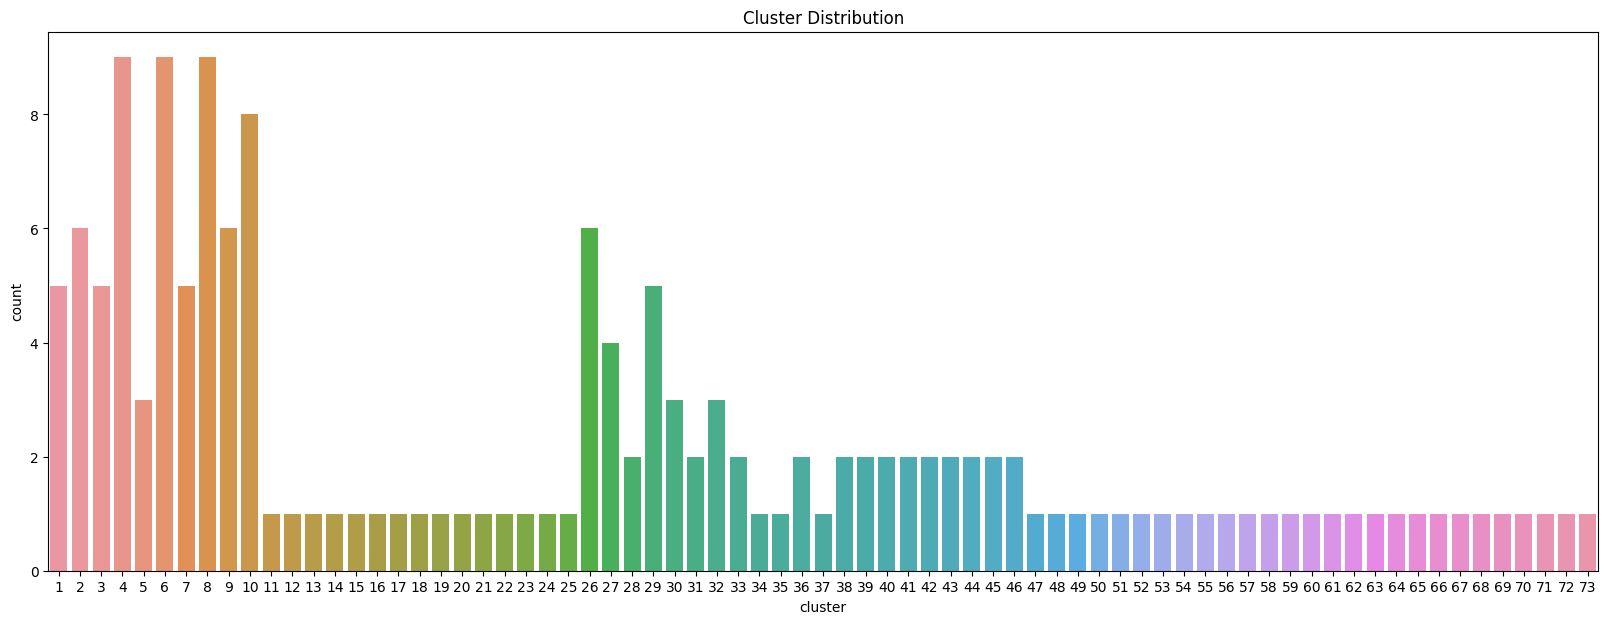

In [7]:
plt.figure(figsize=(20, 7))
sns.countplot(x="cluster", data=data)
plt.title("Cluster Distribution")
plt.show()

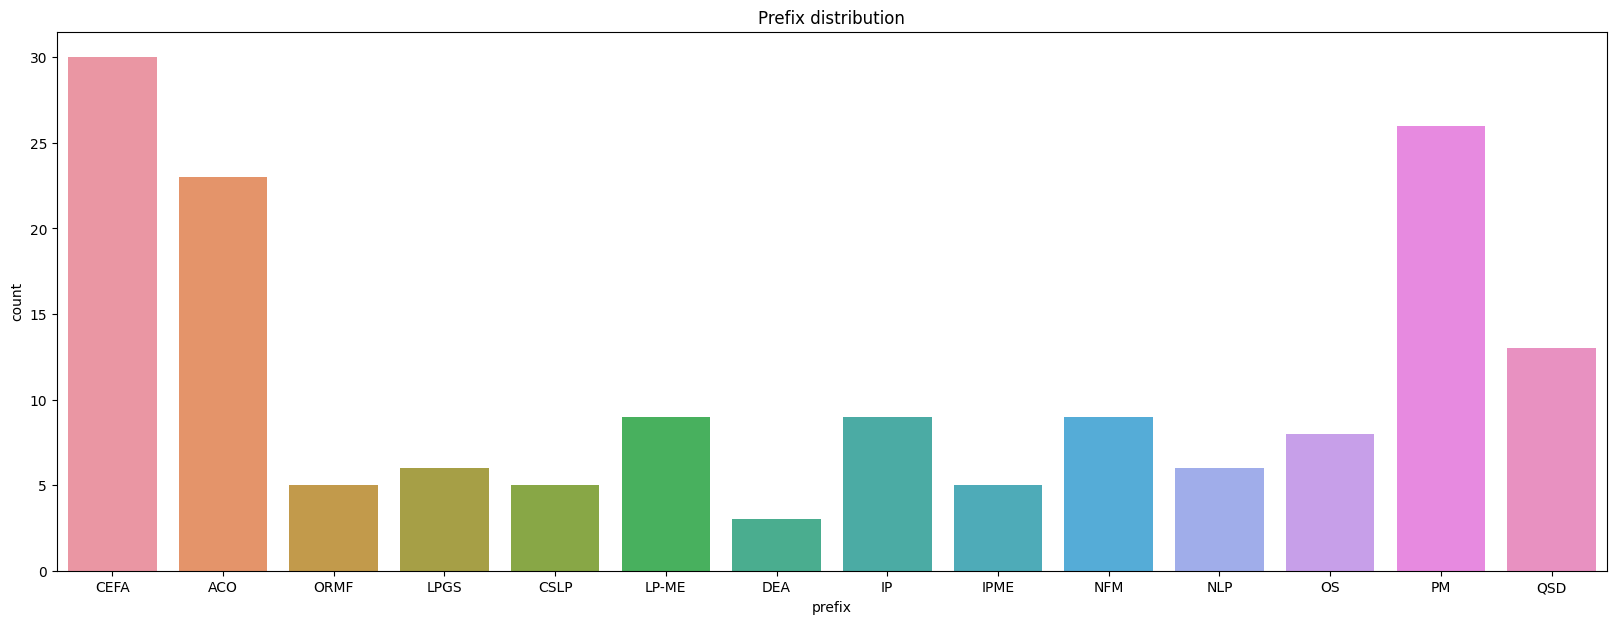

In [8]:
plt.figure(figsize=(20, 7))
sns.countplot(x="prefix", data=data)
plt.title("Prefix distribution")
plt.show()

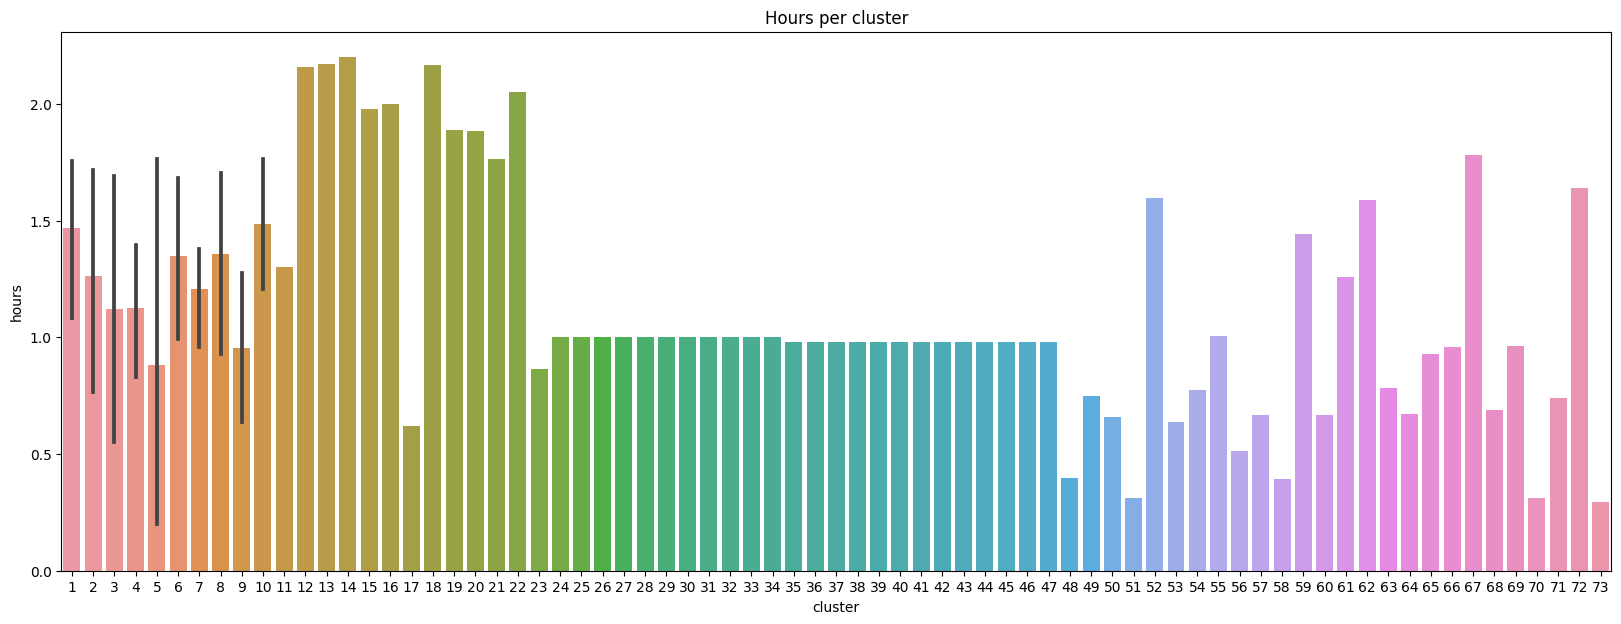

In [9]:
plt.figure(figsize=(20, 7))
sns.barplot(x="cluster", y="hours", data=data)
plt.title("Hours per cluster")
plt.show()

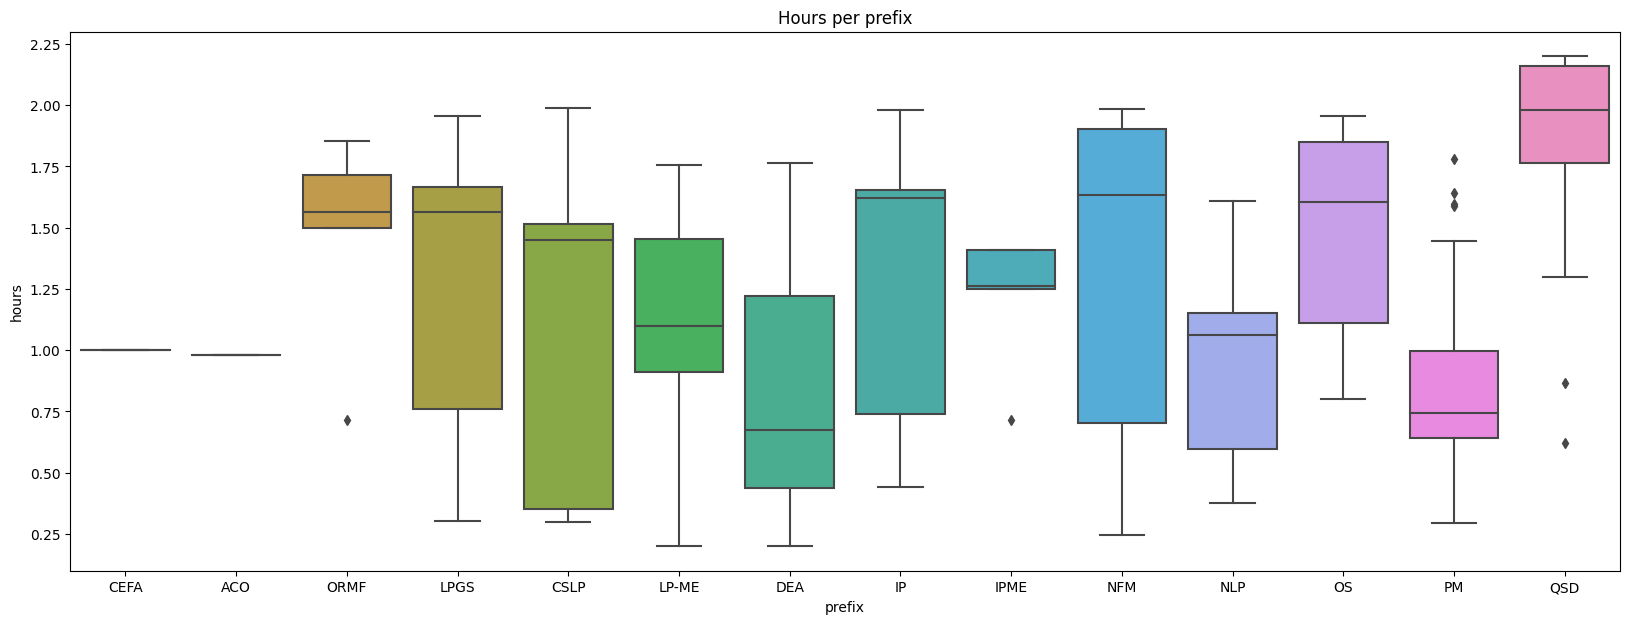

In [10]:
plt.figure(figsize=(20, 7))
sns.boxplot(x="prefix", y="hours", data=data)
plt.title("Hours per prefix")
plt.show()

# Helper utilities


In [11]:
def clean_text(input: str) -> str:
    """
    Clean the text by removing special characters, and digits from the input string.
    """
    import re

    if input == "nan":
        return ""
    return re.sub(
        r"[^a-zA-Z]+",
        " ",
        input.replace("\\'", ""),
    )

In [12]:
def split_camel_case(df: DataFrame, col: str) -> DataFrame:
    """
    Split the words in the DataFrame column which are in camel case.
    """
    lst = list(df[col])

    split_words = []

    for obj in lst:
        split_words.append(clean_text(obj).split())

    payload = [" ".join(entry) for entry in split_words]

    df[col] = payload

    return df

In [13]:
def clean_transcript(input: str) -> DataFrame:
    """
    Clean the transcript by removing special characters and numbers from text.
    """
    import re
    from string import digits

    if input == "nan":
        return ""

    else:
        cleaned = re.sub(
            "([A-Z][a-z]+)",
            r" \1",
            re.sub(
                "([A-Z]+)",
                r" \1",
                re.sub(
                    r"[^a-zA-Z0-9]+",
                    " ",
                    input.replace("\\'", ""),
                ),
            ),
        )

        remove_digits = str.maketrans("", "", digits)

        return cleaned.translate(remove_digits)

In [14]:
def stemmer(df: DataFrame, col: str) -> DataFrame:
    """
    Stem the words in the DataFrame column.
    """
    from collections import defaultdict

    data = df.copy()

    tag_map = defaultdict(lambda: wn.NOUN)

    tag_map["J"] = wn.ADJ
    tag_map["V"] = wn.VERB
    tag_map["R"] = wn.ADV

    data["tokens"] = [word_tokenize(entry) for entry in data[col]]

    stemmer = WordNetLemmatizer()
    for index, entry in enumerate(data["tokens"]):
        final_words = []
        for word, tag in pos_tag(entry):
            word_final = stemmer.lemmatize(word, tag_map[tag[0]])
            if word_final not in stop_words and word_final.isalpha():
                final_words.append(word_final)

        data.loc[index, "target"] = " ".join(final_words)

    return data

# Preprocessing


In [15]:
# split camel case words
# lower all words
# remove special characters and digits
# remove stop words
# stem words

# df = split_camel_case(data, 'features')
# df = split_camel_case(data, 'transcript')

# for each row of the feature column, turn text to lowercase

# df["features"] = [entry.lower() for entry in df["features"]]
# df["transcript"] = [entry.lower() for entry in df["transcript"]]

# df = stemmer(df, "features")
# df = df.drop(columns=["features"])
# df = df.rename(columns={"target": "features"})

# df = stemmer(df, "transcript")
# df = df.drop(columns=["transcript"])
# df = df.rename(columns={"target": "transcript"})

# df = df.drop(columns=["tokens"])

df = data.copy()

df.head()

,name,features,transcript,cluster,number,hours,prefix
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA


In [16]:
# merge features and transcript columns

df["combined"] = (
    "Title: "
    + df.name.str.strip()
    + "; Description: "
    + df.features.str.strip()
    + "; Transcript: "
    + df.transcript.str.strip()
)

df = df.drop(columns=["transcript", "features"])

df.head(20)

,name,cluster,number,hours,prefix,combined
0,Course Introduction,24,1.0,1.0,CEFA,Title: Course Introduction; Description: In th...
1,Business Ethics,25,2.0,1.0,CEFA,Title: Business Ethics; Description: In this l...
2,Introduction to Managerial Finance and Accounting,26,3.0,1.0,CEFA,Title: Introduction to Managerial Finance and ...
3,Introduction to Accounting,26,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...
4,Financial Statements - Income statements and r...,26,3.2,1.0,CEFA,Title: Financial Statements - Income statement...
5,Financial Statements - Balance sheet,26,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...
6,Financial Statements - Cash Flow,26,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...
7,Analyzing Financial Statements and Financial P...,26,3.5,1.0,CEFA,Title: Analyzing Financial Statements and Fina...
8,Analyzing Cash Flow,27,4.0,1.0,CEFA,Title: Analyzing Cash Flow; Description: The k...
9,Cash and Profit Planning,27,4.1,1.0,CEFA,Title: Cash and Profit Planning; Description: ...


# Embedding


In [17]:
encoding = tiktoken.get_encoding(embedding_encoding)

df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(1000)
len(df)

104

In [18]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

In [19]:
df.head()

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
0,Course Introduction,24,1.0,1.0,CEFA,Title: Course Introduction; Description: In th...,6473,"[-0.0039632320404052734, -0.01787586137652397,..."
1,Business Ethics,25,2.0,1.0,CEFA,Title: Business Ethics; Description: In this l...,4952,"[-0.0010639303363859653, -0.026770375669002533..."
3,Introduction to Accounting,26,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,..."
5,Financial Statements - Balance sheet,26,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ..."
6,Financial Statements - Cash Flow,26,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,..."


In [73]:
df["n_tokens"].sum()

400563

In [20]:
matrix = np.vstack(df.embedding.values)
matrix.shape

(104, 1536)

# KMeans Clustering


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0  0  0  0 -1  0 -1  0 -1 -1  0  0  0 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

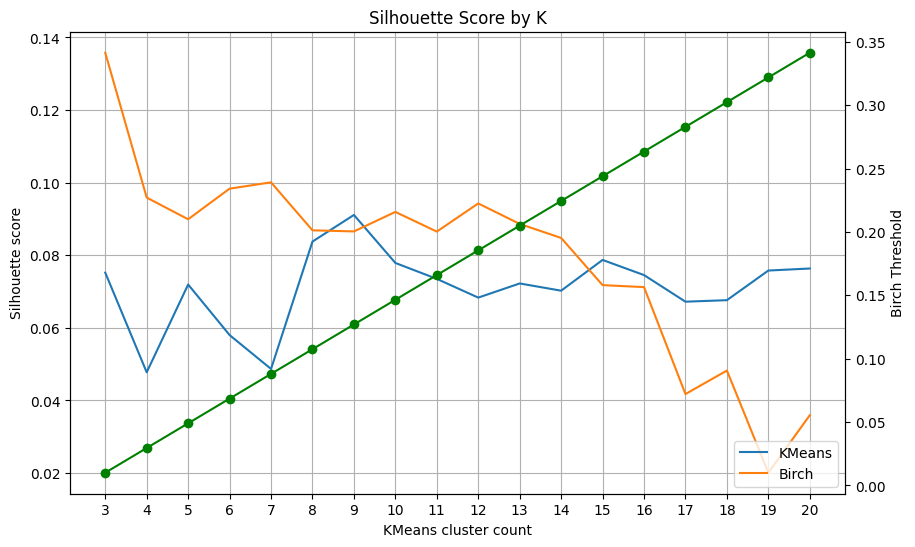

In [112]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, Birch, DBSCAN

best_k = 3
max_k = 21

threshold = np.linspace(0.01, 0.4, max_k)

matrix_copy = matrix.copy()

cluster_results_km = pd.DataFrame(
    {
        "K": range(best_k, max_k),
        "K-Silhouette": np.nan,
        "Birch-Silhouette": np.nan,
        "Birch-Threshold": np.nan,
        "DBSCAN-Silhouette": np.nan,
        "DBSCAN-eps": np.nan,
        "DBSCAN-min-sample": np.nan,
    }
)
cluster_results_km.set_index("K", inplace=True)


for k in range(best_k, max_k):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init="auto")
    kmeans.fit(matrix_copy)
    labels_k = kmeans.labels_
    cluster_results_km.loc[k, "K-Silhouette"] = silhouette_score(matrix_copy, labels_k)

    birch = Birch(n_clusters=k, threshold=threshold[k - best_k])
    birch.fit(matrix_copy)
    labels_birch = birch.predict(matrix_copy)
    cluster_results_km.loc[k, "Birch-Silhouette"] = silhouette_score(
        matrix_copy, labels_birch
    )
    cluster_results_km.loc[k, "Birch-Threshold"] = threshold[k - best_k]

    dbscan = DBSCAN(eps=k * 0.1, min_samples=5)
    dbscan.fit(matrix_copy)
    labels_dbscan = dbscan.labels_
    print(labels_dbscan)
    # cluster_results_km.loc[k, "DBSCAN-Silhouette"] = silhouette_score(
    #     matrix_copy, labels_dbscan
    # )
    # cluster_results_km.loc[k, "DBSCAN-eps"] = k * 0.1
    # cluster_results_km.loc[k, "DBSCAN-min-sample"] = 5

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(cluster_results_km.index, cluster_results_km["K-Silhouette"], label="KMeans")
ax1.plot(
    cluster_results_km.index, cluster_results_km["Birch-Silhouette"], label="Birch"
)
ax1.set_ylabel("Silhouette score")
ax1.set_xlabel("KMeans cluster count")
ax1.set_xticks(range(best_k, max_k))


ax2 = ax1.twinx()
ax2.plot(
    cluster_results_km.index,
    cluster_results_km["Birch-Threshold"],
    label="Birch-Threshold",
    color="green",
    marker="o",
)
ax2.set_ylabel("Birch Threshold")
ax1.set_title("Silhouette Score by K")
ax1.grid(True)
ax1.legend(loc="lower right")
plt.show()

best_k = cluster_results_km["K-Silhouette"].idxmax()
best_birch = cluster_results_km["Birch-Silhouette"].idxmax()
best_threshold = cluster_results_km.loc[best_birch, "Birch-Threshold"]

In [42]:
cluster_results_km.head(10)

,K-Silhouette,Birch-Silhouette,Birch-Threshold
K,,,
3,0.075205,0.135789,0.0100
4,0.047745,0.095881,0.0295
5,0.071930,0.089909,0.0490
6,0.058008,0.098339,0.0685
7,0.048671,0.100077,0.0880
8,0.083762,0.086860,0.1075
9,0.091097,0.086556,0.1270
10,0.077874,0.091933,0.1465
11,0.073485,0.086510,0.1660


In [23]:
n_clusters = best_k

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init="auto")
kmeans.fit(matrix_copy)
labels = kmeans.labels_
df["cluster"] = labels

birch = Birch(n_clusters=best_birch, threshold=best_threshold)
birch.fit(matrix_copy)
labels = birch.predict(matrix_copy)
df["birch"] = labels

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(matrix_copy)
labels = dbscan.labels_
df["dbscan"] = labels

# Evaluation


In [24]:
kmean_score = silhouette_score(matrix, df.cluster).round(4)
birch_score = silhouette_score(matrix, df.birch).round(4)
dbscan_score = silhouette_score(matrix, df.dbscan).round(4)

print(f"KMeans silhouette score: {kmean_score}")
print(f"Birch silhouette score: {birch_score}")
print(f"DBSCAN silhouette score: {dbscan_score}")

KMeans silhouette score: 0.0911
Birch silhouette score: 0.1358


In [25]:
df.head()

,name,cluster,number,hours,prefix,combined,n_tokens,embedding,birch
0,Course Introduction,5,1.0,1.0,CEFA,Title: Course Introduction; Description: In th...,6473,"[-0.0039632320404052734, -0.01787586137652397,...",2
1,Business Ethics,6,2.0,1.0,CEFA,Title: Business Ethics; Description: In this l...,4952,"[-0.0010639303363859653, -0.026770375669002533...",1
3,Introduction to Accounting,3,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,...",2
5,Financial Statements - Balance sheet,3,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ...",2
6,Financial Statements - Cash Flow,3,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,...",2


/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_89889/2508447874.py:35: RuntimeWarning: Mean of empty slice.
  avg_x2 = xs2.mean()
/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_89889/2508447874.py:36: RuntimeWarning: Mean of empty slice.
  avg_y2 = ys2.mean()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


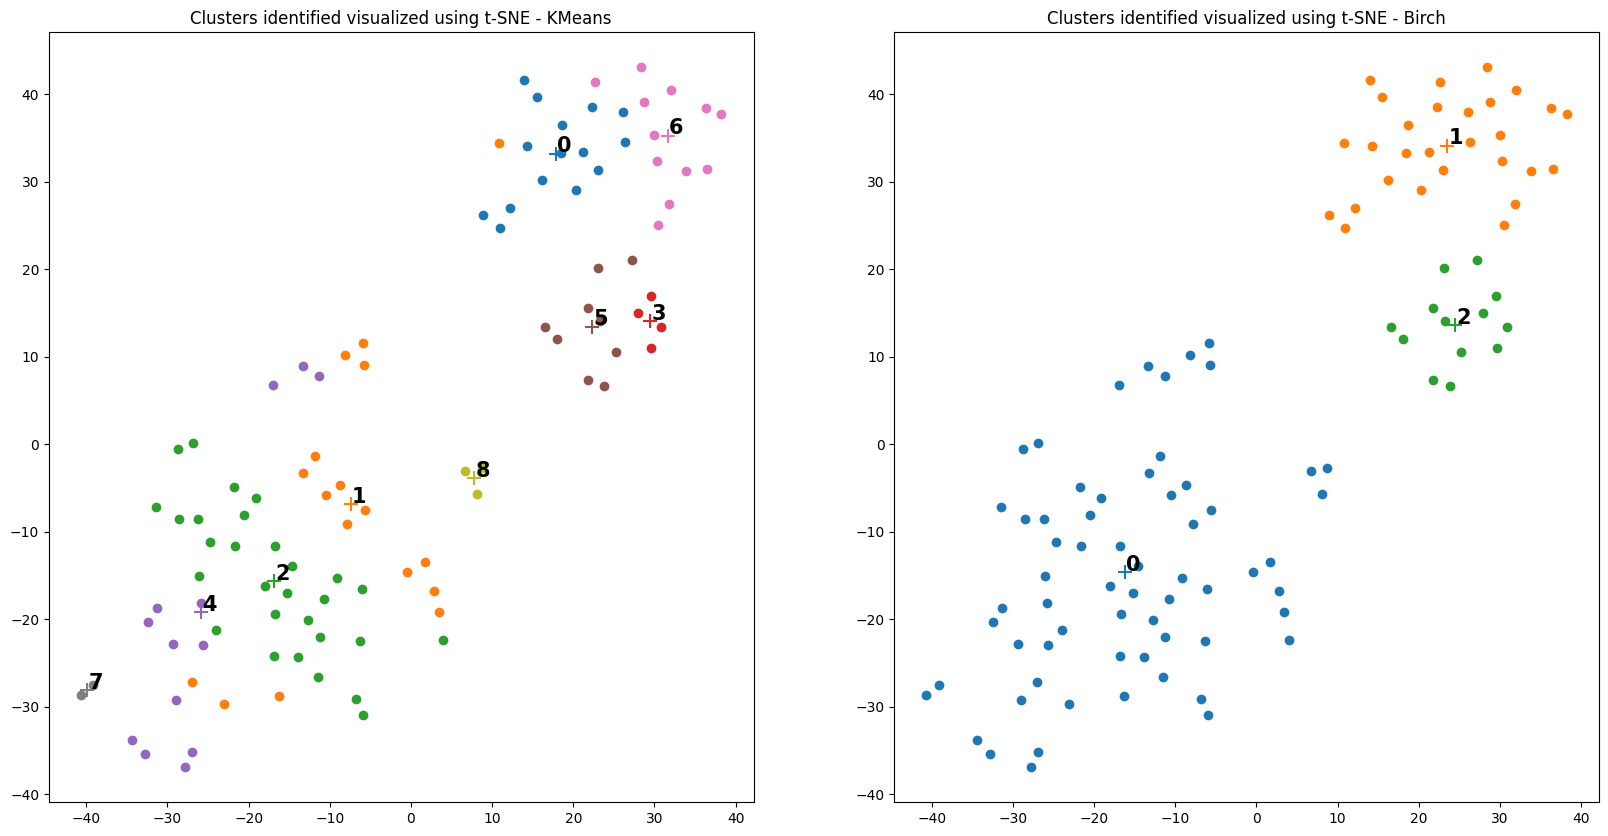

In [101]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(
    n_components=2, perplexity=16, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

if n_clusters > 10:
    palette = sns.color_palette("tab20", n_clusters).as_hex()
else:
    palette = sns.color_palette("tab10", n_clusters).as_hex()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# plt.scatter(x, y, alpha=1, ax=ax[0])

for category, color in enumerate(palette):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    avg_x = xs.mean()
    avg_y = ys.mean()

    ax[0].scatter(xs, ys, color=color, alpha=1)
    ax[0].text(avg_x + 0.15, avg_y + 0.15, category, fontsize=15, fontweight="bold")
    ax[0].scatter(avg_x, avg_y, marker="+", color=color, s=100)
    ax[0].set_title("Clusters identified visualized using t-SNE - KMeans")

    xs2 = np.array(x)[df.birch == category]
    ys2 = np.array(y)[df.birch == category]
    avg_x2 = xs2.mean()
    avg_y2 = ys2.mean()

    ax[1].scatter(xs2, ys2, color=color, alpha=1)
    ax[1].text(avg_x2 + 0.15, avg_y2 + 0.15, category, fontsize=15, fontweight="bold")
    ax[1].scatter(avg_x2, avg_y2, marker="+", color=color, s=100)
    ax[1].set_title("Clusters identified visualized using t-SNE - Birch")

plt.show()

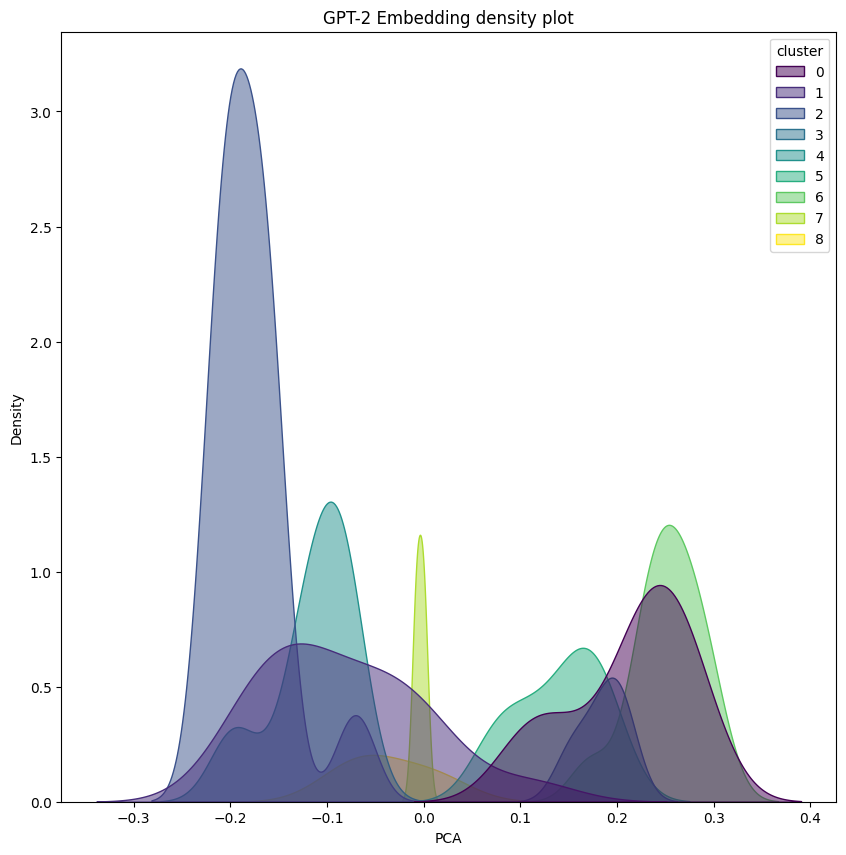

In [72]:
from sklearn.decomposition import PCA

pca_data = df.copy()

pca = PCA(n_components=1)
pca_data["PCA"] = pca.fit_transform(matrix)

# x = pca.components_[0]

plt.figure(figsize=(10, 10))

sns.kdeplot(
    pca_data["PCA"], shade=True, hue=pca_data["cluster"], alpha=0.5, palette="viridis"
)

# plt.scatter(x, y, alpha=0.5)
plt.title("GPT-2 Embedding density plot")
plt.show()

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.birch, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         4

    accuracy                           0.90        21
   macro avg       0.92      0.83      0.85        21
weighted avg       0.92      0.90      0.89        21



In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values),
    df.cluster,
    test_size=0.2,
    random_state=42,
    stratify=df.cluster.values,
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      0.67      0.67         3
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00         1
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1

    accuracy                           0.81        21
   macro avg       0.77      0.75      0.74        21
weighted avg       0.80      0.81      0.77        21



RandomForestClassifier() - Average precision score over all classes: 0.88


/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


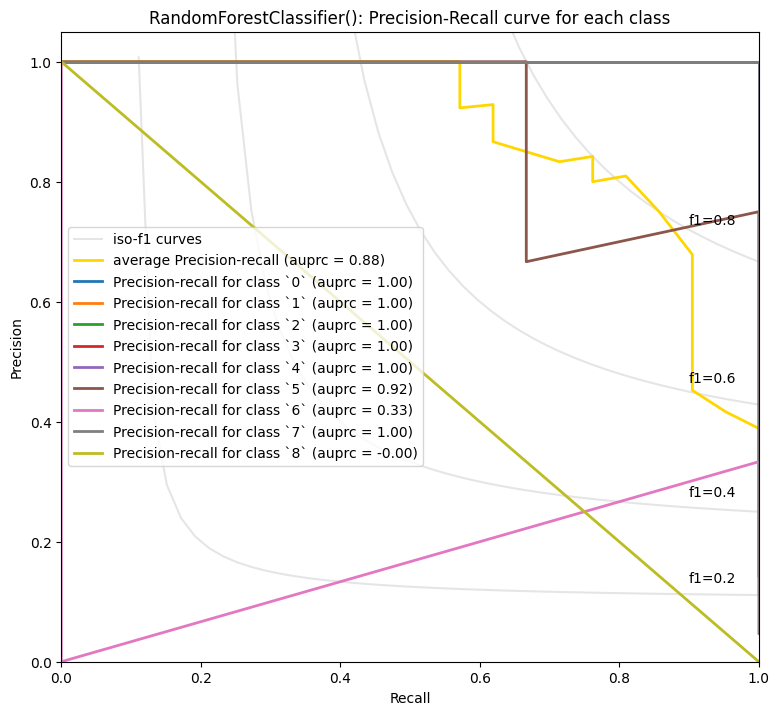

In [182]:
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, range(n_clusters), clf)

# Verification


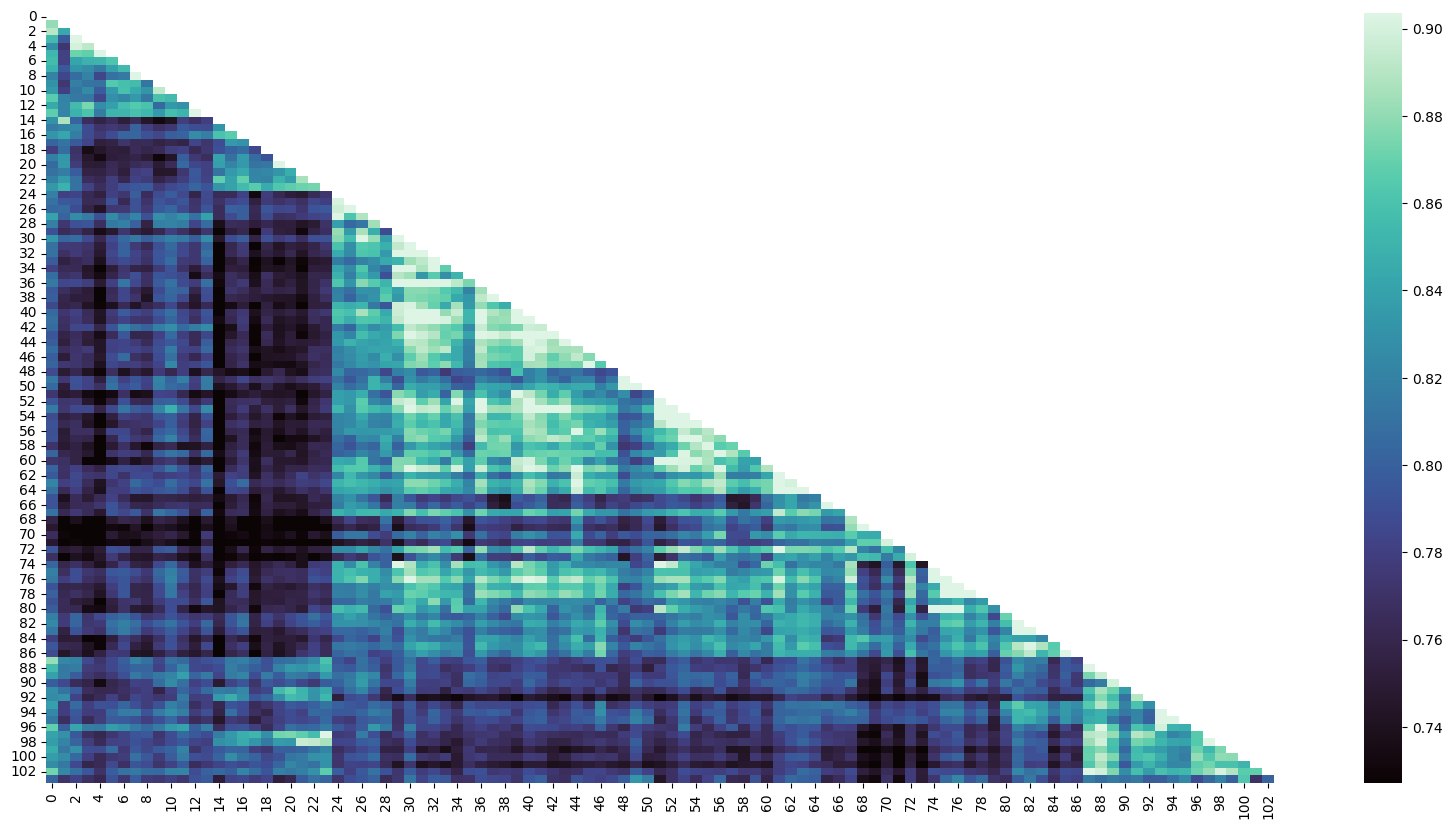

In [183]:
# cosine similarity between all embeddings

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(matrix)

# generate heatmap from sims

import seaborn as sns

plt.figure(figsize=(20, 10))

mask = np.triu(np.ones_like(cosine_sim, dtype=bool))

sns.heatmap(
    cosine_sim,
    cmap="mako",
    mask=mask,
    robust=True,
    square=False,
    annot=False,
    fmt=".2f",
)

plt.show()

In [184]:
df.groupby("cluster").size().sort_values(ascending=False)

cluster
2    29
1    17
0    15
4    13
6    12
5     9
3     4
8     3
7     2
dtype: int64

<AxesSubplot:title={'center':'Total hours by cluster'}, xlabel='cluster'>

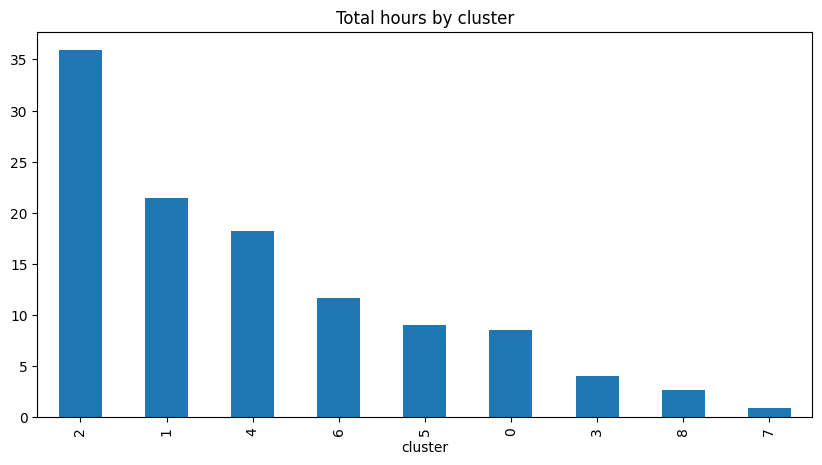

In [185]:
df[["name", "cluster", "prefix", "hours"]].groupby("cluster").sum().sort_values(
    by="hours", ascending=False
).plot(kind="bar", figsize=(10, 5), legend=False, title="Total hours by cluster")

<AxesSubplot:title={'center':'Total instances by prefix'}, xlabel='prefix'>

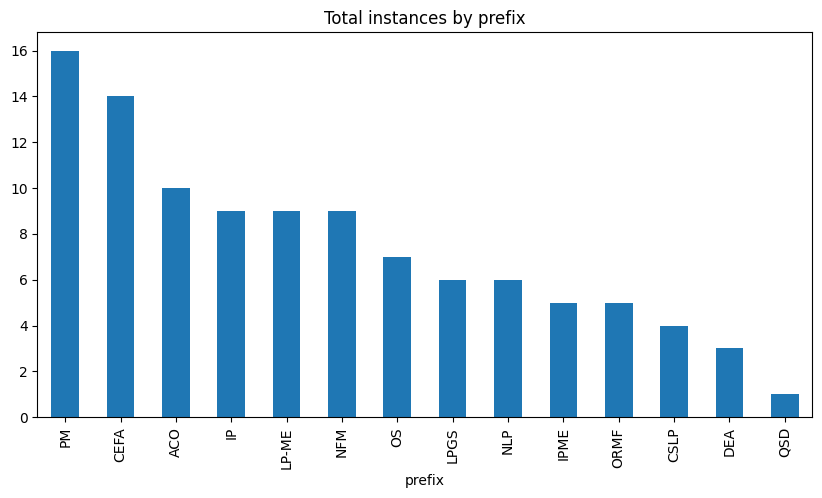

In [186]:
# count the number of instances for each unique prefix value
df.groupby("prefix").size().sort_values(ascending=False).plot(
    kind="bar", figsize=(10, 5), legend=False, title="Total instances by prefix"
)

<AxesSubplot:title={'center':'Total instances by cluster'}, xlabel='cluster'>

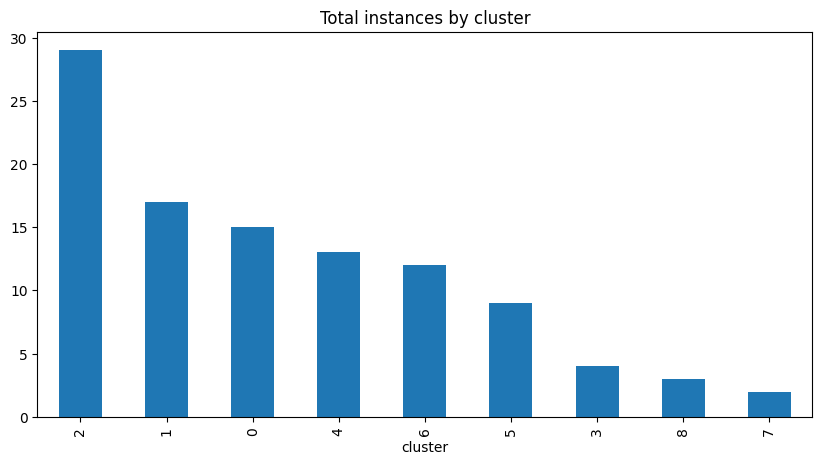

In [108]:
# count the number of instances for each unique prefix value
df.groupby("cluster").size().sort_values(ascending=False).plot(
    kind="bar", figsize=(10, 5), legend=False, title="Total instances by cluster"
)

In [187]:
df[df.cluster == 7]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding,birch
95,Introduction to Network Flow Models,7,8.0,0.245521,NFM,Title: Introduction to Network Flow Models; De...,118,"[-0.005312740337103605, 0.012432942166924477, ...",0
96,Network Flow Models,7,8.1,0.614819,NFM,Title: Network Flow Models; Description: Ident...,710,"[-0.005887497216463089, 0.010028370656073093, ...",0


In [188]:
df[df.cluster == 8]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding,birch
78,Introduction to Data Envelopment Analysis,8,5.0,0.200000,DEA,Title: Introduction to Data Envelopment Analys...,177,"[0.00044611189514398575, 0.007658941205590963,...",0
79,Data Envelopment Analysis,8,5.1,0.675300,DEA,Title: Data Envelopment Analysis; Description:...,7085,"[-0.01847120001912117, -0.012827222235500813, ...",0
80,Data Envelopment Analysis Applications,8,5.2,1.764842,DEA,Title: Data Envelopment Analysis Applications;...,3521,"[-0.01884360983967781, -0.00622345507144928, 0...",0


In [189]:
df[df.cluster == 3]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding,birch
3,Introduction to Accounting,3,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,...",2
5,Financial Statements - Balance sheet,3,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ...",2
6,Financial Statements - Cash Flow,3,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,...",2
8,Analyzing Cash Flow,3,4.0,1.0,CEFA,Title: Analyzing Cash Flow; Description: The k...,5488,"[-0.030511444434523582, -0.004694812931120396,...",2


# Mapping collections to sections

- Generate a number of learning outcomes for each cluster
- Retrieve course and section data
- Run embedding on section learning objectives
- Pair each section with a number of clusters that have the highest cosine similarity to the section (difference threshold of 0.2)


In [190]:
doc_per_cluster = 2

for i in range(n_clusters):
    print(f"Cluster {i} Topic:", end=" ")

    docs = "\n".join(
        df[df.cluster == i]
        .combined.map(lambda x: x[:1000])
        .sample(doc_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What best describes the commonality shared between the following documents?\n\nDocuments:\n"""\n{docs}\n"""\n\nTopic:',
        temperature=0.4,
        max_tokens=64,
        top_p=1,
        frequency_penalty=1,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", " "))

Cluster 0 Topic:  The commonality shared between the two documents is that they both discuss project management and leadership. They both cover topics related to the roles, responsibilities, and skills needed for successful project management. They also emphasize the importance of developing soft skills for success in project management careers.
Cluster 1 Topic:  The commonality shared between the two documents is that they both discuss operations research (OR) and its applications. They cover topics such as problem definition, optimization objectives, constraints, linear programming, decision making, mathematical models, transportation models, inventory models, queuing models, sensitivity analysis and break-even point.
Cluster 2 Topic:  Facility and Transportation System Modeling
Cluster 3 Topic:  Financial Statements and Cash Flow Analysis
Cluster 4 Topic:  Scheduling and Network Flow Problems
Cluster 5 Topic:  The commonality shared between the documents is that they both discuss fi